# Build A Satellite Image Memory Palace Using Python & Google Colab


During memory palace creation, most individuals use real life rooms or buildings, photos, and floor plans.  

While the primary concept of a memory palace is to store information as images within the mind, in the end, you can still forget about entire memory palaces by forgetting that you created it in the first place.

There is also a limit to the amount of palaces/locis* you can create and memorize, as we only have so much time, imaginative energy, and willpower to create them. Everyone has this upper limit. One of my main questions is to learn how we can increase this limit using technology.

The codified memory palace solution presented here in a prototype form aims to resolve some of these problems by giving individuals the capacity to have a long-term memory palace that they can use to store anything they want within real world locations that they can walk through, or veiw on a digital map.

I personally prefer the outdoor, path oriented memory palace that is used in this solution, in contrast to the room or building based palace. This is because it has greater potential for using our spacial memory, and also allows for more natural recall while walking through a large open area.

The program written in the Python Programming Language below takes in a specific GPS coordinate and generates a list of earth coordinates for a given area.

The output of these coordinates forms a matrix around the specific coordinate, which we can now call the center coordinate, or center of the memory palace. You can determine how big or small the palace is, as well as the distance between points using the code below. My current palace holds over 10,000 locis, and I have plans to expand it to 1 million to increase it's flexibility.

You can then enter images that represent the concepts that you're trying to remembering into this palace, and it will display them onto an interactive map, such as in an other mapping applications like Google & Apple Maps.

Let's get started.


*In saying locis, I refer to the specific positions where images are stored, which is common when discussing memory palaces. In this walkthrough I'll continue to refer to locis, coordinates, and locations interchangeably.


## Imports

The below libraries are needed to run the memory palace generating code.

In [40]:
import os
from pathlib import Path
import numpy as np
import folium
from PIL import Image

## Functions

The first two functions below generate the memory palace coordinates. I found them online via StackOverflow, and they work very well for our situation.

The second funciton aims to clean up the images for displaying them on the HTML map.

In [41]:
# Function to offset lat, long, with x & y in meters
def lat_long_offset(lat, lon, x, y):
    '''
    Note from creator (https://stackoverflow.com/questions/69409596/how-can-i-create-grid-of-coordinates-from-a-center-point-in-python)
    lat, lon : Provide lat lon coordinates
    x, y : Provide offset of x and y on lat and long respectively
           This needs to be in meters!

    The approximation is taken from an aviation formula from this stack exchange
    https://gis.stackexchange.com/questions/2 pm 951/algorithm-for-offsetting-a-latitude-longitude-by-some-amount-of-meters
    '''
    # Earth's radius, sphere
    R=6378137

    # Coordinate offsets in radians
    dLat = x/R
    dLon = y/(R*np.cos(np.pi*lat/180))

    # OffsetPosition, decimal degrees
    latO = lat + dLat * 180/np.pi
    lonO = lon + dLon * 180/np.pi

    return latO, lonO

# Create a vectorized offset function, pushes geo input through np.vectorize
lat_long_offset_vec = np.vectorize(lat_long_offset)


# Create offset_grid and return coordinates
def get_mesh(lat, lon, dist, coors):
  # Calculate - and max range over an axis to create grid (both directions)
  mini, maxi = -dist*coors, dist*coors

  # Calculate number of points over axis, both ways + center point
  n_coord = coors*2+1

  # Create an axis from min to max value with required number of coordinates
  axis = np.linspace(mini, maxi, n_coord)

  # Create an "offset_grid" for X and Y values for both axis
  X, Y = np.meshgrid(axis, axis)


  # Calculate offset coordinates for "offset_grid" in meters
  mesh = lat_long_offset_vec(lat, lon, X, Y)

  # Transpose to get the (x,y) values for the offset_grid's shape
  mesh_x_y_format = np.stack(mesh).transpose(1, 2, 0)

  return mesh_x_y_format

In [42]:
def static_image(image_file_name):
  '''
  The aim of this funciton is to convert and transform images to a stable state
  through which all memory palace functions can be ran. This also will improve visibility of images on maps.

  Also, the mapping function can start to run slowly from from large
  images, or large quantities of images. So making them smaller here
  may improve speed as well as increase the image cap.
  '''

  im = Image.open(image_file_name)
  im_copy = im.copy()
  im_copy.convert('RGBA')
  im_copy.thumbnail((200, 200))
  w, h = im_copy.size

  final_image = Image.new('RGBA', (w, h))
  final_image.paste(im_copy, (0,0))

  # Creating folder path to save image to, so we can still use
  # a path name for folium maps.

  # Saving image to path
  path = '/content/mapping_images' # Change this to your path
  head, tail = os.path.split(image_file_name)
  name, extension = os.path.splitext(tail)
  full_path = Path(path) / Path(name + '-' + extension)
  final_image = final_image.save(full_path)

  return full_path # This path is then used when mapping the image onto the folium map

# Creating the folder for static_image() to dump into
!mkdir /content/mapping_images


mkdir: cannot create directory ‘/content/mapping_images’: File exists


## Code

### Generate the Memory Palace Coordinates

Below, we generate the memory palace coordinates by feeding get_mesh() a lattitude and longitude pisition, a distance parameter in meters (the total distance between coordinates), and the desired number of coordinates over a specific axis.

The coordinate total per axis will be doubled when calcualting the coordinates in both directions, plus the center point.

In the example below we use 50, and get 101 lines and 101 points for each line as a result, totaling 10201 total coordinates that we can use for building a memory palace.

In [43]:
'''
Change the lat & lon below to the center coordinates of the palace you would like to create.

The below coordinates are located at Dry Creek Open Space in Colorado. This is my current mega-memory palace.

'''
lat = -33.58
lon = 18.35
center_point = lat, lon # This will be used later for other functions

palace_coords = get_mesh(lat, lon, 9, 50)

In [44]:
# There are 101 lines of coordinates in this palace
len(palace_coords)

101

In [45]:
# Each line has 101 points
len(palace_coords[0])

101

In [46]:
# The total amount of coordinates or locis, then, is:
101 * 101

10201

In [47]:
# To access a specific coordinate, you may call it's correlary 0-100, 0-100 number pair (python indexs start at 0, not 1)
first_loci = palace_coords[0][0]
last_loci = palace_coords[100][100]

first_loci

array([-33.58404242,  18.34514782])

#### Display Loci Coordinates on the Map

After tinkering with the folium map for a while, I came up with the following set-up.

You may adjust this as you please. I recommmend checking out Folium's documentation or StackOverflow for tweaking this.

The Ersi Satalite tiles displayed below are free to use, and work very well unless you would like a very high definition view as seen on Google Maps.

In [48]:
# Code to display map w/ marker of your Center Point & the first & last loci
map = folium.Map(location = (center_point), height = 700, width = 700, zoom_start = 11,
                  zoom_control=True, scrollWheelZoom=True,
                  dragging=True, no_touch=False, )
tile = folium.TileLayer(
      tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
      attr = 'Esri',
      name = 'Esri Satellite',
      overlay = False,
      control = True
    ).add_to(map)

# Adding a marker for the center point
folium.Marker(
        [lat, lon], popup='<i>' + 'The Center Point' + '</i>').add_to(map)

# # Adding markers for the first & last loci
# folium.Marker(
#         first_loci, popup='<i>' + 'First Loci' + '</i>').add_to(map)

# folium.Marker(
#         last_loci, popup='<i>' + 'Last Loci' + '</i>').add_to(map)

map # Displaying map, if it does not show zoom out and then zoom back in to the markers/images once you see them

As you can see in the map above by clicking on each marker, the bottom left corner displays the first loci position, while the middle displays the center and the marker at the top right displays the last loci position (if you were to place images from the beginning to end, and from left to right along the map).

We can finish out the visualization of the matrix by adding in a top left corner and bottom right corner marker to see the bounds of our codified memory palace, as shown below.

In [49]:
top_left_corner_loci = palace_coords[0][100]
top_left_label = 'Top Left Corner'

bottom_right_corner_loci = palace_coords[100][0]
bottom_right_label = 'Bottom Right Corner'

# Add markers for each
folium.Marker(
        top_left_corner_loci, popup='<i>' + top_left_label + '</i>').add_to(map)

folium.Marker(
        bottom_right_corner_loci, popup='<i>' + bottom_right_label + '</i>').add_to(map)

map # Displaying map, if it does not show zoom out and then zoom back in to the markers/images once you see them

### Display an Image on the Map

Below we will take an image from my memory palace & insert into the map below. The image is of someone washing their hands (I practice recalling my memory palace anytime I wash my hands, so this seemed to be an apt selection).

This image is a PNG image with a transparant background, which I tend to use while building memory palaces because it 'melds' into the palace background being used more effectively.



In [ ]:
'''
During my normal memory palace creation process, I have a filing system for placing images into my palace by moving images into specific folders with specific file names.

The folder names represent loci positions (such as 05-05), which then automatically refer to earth coordinates. This makes it very easy
to drop loci images into specific locations.

For your personal use: You can use any file path location of a desired image, which can then be built into the folium marker.

If you run this program via Google Colab, I recommend creating a Google Drive account and then mounting it onto your Colab notebook.

The following code allows me to get images from my memory palace and use them in this notebook, without the need to mount Google Drive.

If you so wish, this will allow you to use and alter this memory palace if you select the "save a copy in drive" option in the toolbar at
the top of this notebook.
'''

# Copying my memory palaces images to this notebooks files (link to shared files: https://drive.google.com/drive/folders/1-i5vnwCfkj3eit2zk8TQgQqcbYlPIRQdhttps://drive.google.com/drive/folders/1-i5vnwCfkj3eit2zk8TQgQqcbYlPIRQd)
!mkdir /content/loci_images
!gdown https://drive.google.com/drive/folders/1-i5vnwCfkj3eit2zk8TQgQqcbYlPIRQd -O /content/loci_images --folder


Retrieving folder list
Processing file 1hYhoWFaAp9nKZ_UHd7IIF44eYp-MrtWO 05-05-WashingHandsTrigger-R055005-R505050.png
Processing file 1jtRMPneoM3vMnHEbILVMvvSY2fBkO00t 05-15-ArtOfMemoryByFrancesYates.png
Processing file 1uzAW9aF1o310FN2detImB-eYhxRvgpFz 31-30-Ergodicity-ContraAbsorbingState+Barrier-R760115.png
Processing file 1-7YrqtkXjkCwIgWiu2y1d62ToZUG8ikB 65-02-IfEmotionallyUpsetDoTaiChi.png
Processing file 1lEtnGXR9HzkKBrqLdtabF-vm56ygVmYV 65-80-DestroyExpectation.png
Processing file 1eEoXnws0sBSCjHfSKuhVncHiNJWUai2K 76-15-SkinInTheGame-R707070.png
Processing file 1CnCnSoaORZiQ6fcQm9Qys9uogUExEg12 80-70-Seneca.PNG
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1hYhoWFaAp9nKZ_UHd7IIF44eYp-MrtWO
To: /content/loci_images/05-05-WashingHandsTrigger-R055005-R505050.png
100% 564k/564k [00:00<00:00, 73.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1jtRMPneoM3vMnHEbILVMvv

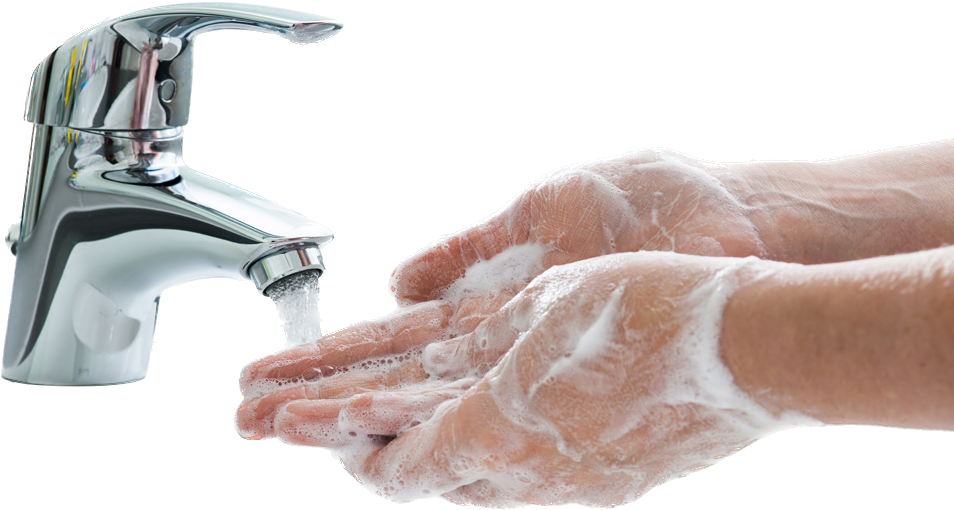

In [ ]:
# Displaying the loci image from files
image = '/content/loci_images/05-05-WashingHandsTrigger-R055005-R505050.png'

im = Image.open(image)
im


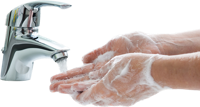

In [ ]:
# Getting the 'Washing Hands' Loci position. This is where I have this image stored in my memory palace
loci_position = palace_coords[5][5]

# This label will be used to identify the title or any text information in the image. I usually just use a file name
label = 'Recall Memory Palace Objects While Washing Hands'

# This is taken from the output image size of static_image(), and is used to set the icon_size
w, h = 200, 200

# Static image renders the image for the image mapping process below
image_file_name = str(static_image(image))

# The code below creates the icon to place on the map (the image is also transformed to 50% the original image)
icon = folium.features.CustomIcon(icon_image = image_file_name,
                                  icon_size= ((w * .50),(h * .50)))

# Now, we can place the image on the map, and see how it turns out
marker = folium.Marker(loci_position, popup = label,
                        icon=icon).add_to(map)

map # Displaying map, if it does not show zoom out and then zoom back in to the markers/images once you see them

## Ideas for Automating the Process
I currently have automated this process by storing images in specific folders labled by the loci posiitons (just as 'Washing Hands' is stored in 05-05).

I did this by running a program that created about 10,000 folders in my Google Drive account.

Whenever I want to add an image to my palace, I'll give it a title and drop it in it's corresponding location folder.

Then, I'll run a program to automatically pull the images from my Google Drive folders, transform them, and them display them on this map to see where it is.*

I'll often walk around this memory palace and think of all the images I have stored in it to strengthen my recall.

This works very well as a long-term solution to creating and using memory palaces with the intention of storing large amounts of data. I no longer have multiple palaces scattered all over the place.

If you like, you can us this to organize all of your current palaces into one location by placing thier images on this map.

*There is a limit to the amount of images you can display using this method, depending on your computational resources as well as folium itself. I'm currently looking for better (yet simple) ways to generate these palaces. If you find one that works well for you, please reach out to me at Austin@mooreaustin.com.

#### Map Screenshot

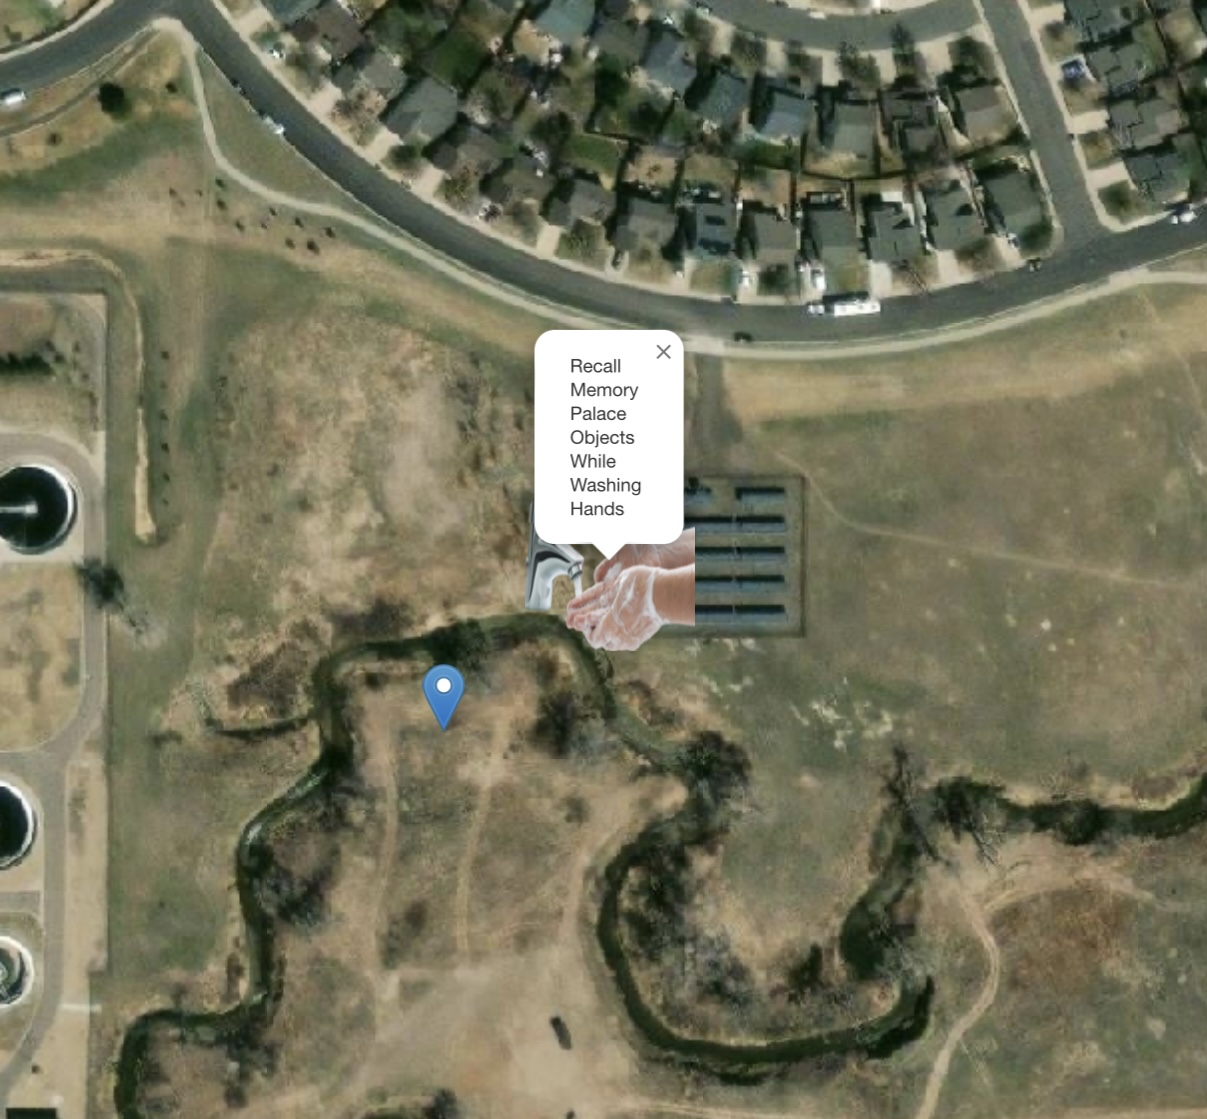

As you can see above, the image is transposed ontop of the interactive map. You can then scroll around the map and zoom in to see exactly where the image is located. You can change the image size as you see fit. With these settings, it remains constant regardless of zoom level

You can also click or tap on the image to see the label hidden inside the image.

## Automation Example

The code below takes all the images stored in the loci_images folder which we downloaded to this notebook earlier and places them in the loci positions signified in the images title.

The output map below shows the file name of each image to demonstrate the ease of placing images simply by changing their file name in your Google Drive or computers files.

Again: I use my phone as a simple and easily accessible format to build my memory palaces. I will do this until (and if!) I or someone else builds a mobile memory palace application that replicates this format.


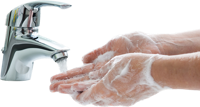
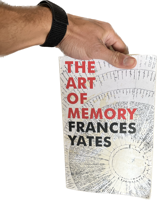
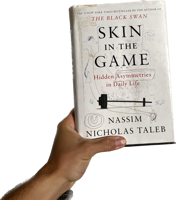
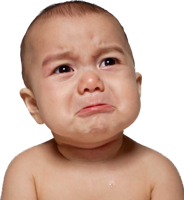
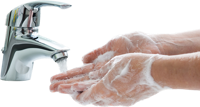
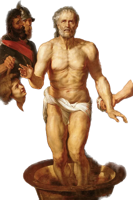
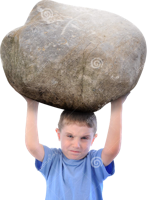
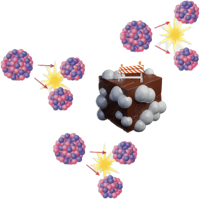

In [ ]:
# Getting file_name list of all palace images
image_folder = '/content/loci_images/'
image_file_names = os.listdir(image_folder)

# Adding each image to map, we we did with Washing Hands
for file_name in image_file_names:

  # Validating file type and excluding all others
  if file_name.lower().endswith('.png'):

  # Getting the Loci position from file_name. This is where I have this image stored in my memory palace.
    x = int(file_name[0:2])
    y = int(file_name[3:5])

    loci_position = palace_coords[x][y]

    label = 'File Name: ' + file_name + ' ---> ' +'Loci Position: ' + str(x).zfill(2) + '-' + str(y).zfill(2)

    # Constructing Path to Image
    image = image_folder + file_name

    # This is taken from the output image size of static_image(), and is used to set the icon_size
    w, h = 200, 200

    # Static image renders the image for the image mapping process below
    image_file_name = str(static_image(image))

    # The code below creates the icon to place on the map (the image is also transformed to 50% the original image)
    icon = folium.features.CustomIcon(icon_image = image_file_name,
                                      icon_size= ((w * .50),(h * .50)))

    # Now, we can place the image on the map, and see how it turns out
    marker = folium.Marker(loci_position, popup = label,
                            icon=icon).add_to(map)


map # Displaying map, if it does not show zoom out and then zoom back in to the markers/images once you see them

### Image Descriptions:

As you can see, we get some pretty rediculous outputs from this palace generator.

Why is a hand coming out of the baby's head? This is a random, positive consequence of grouping all of these images together, as it makes the entire palace more memorable via humor and weirdness.

Each image is an item I have stored in my palace. The file name helps remind me of the meaning of the image, and also helps me search for it if I'd like to use it somewhere else in the palace, or for a project.

I store all of my personal notes in this fashion: Even those for work and coding projects.

This way, I know where each item is, and know the information, tools, and resources at my disposal at all times: Mentally, and technologically.

Below are a few explanations for the images...

#### 05-15:
If you love memory palaces, this is a must-read. Francis Yates digs into the the top historical figures use of memory palaces since Simonides of Ceos (500 B.C).

#### 80-70 & 65-80:
On the right Seneca the Stoic Philosopher is displayed, and on his left, a kid holds up a giant rock. Stoic philosophy has historically helped individuals endure hardships and succeed in life, regardless of their external circumstances. Seneca has written a lot on these topics, one of them being on the concept of 'Destroying Expectation'. The kid with the rock reminds me of this concept.

#### 76-15 & 05-15:
Two books are shown here, and both of their locations include 15 in the Y coordinate. This is not by mistake: Each number from 0-99 represents a general category with sub-tags. If it fits two categories, this becomes the automatic location of the palace. 05-15 refers to MemoryPalaces-Books. 76-15 refers to Ethics-Books, hence Nassim Taleb's book 'Skin in the Game'.

#### 76-15 & 31-30:
These two images are connected in my memory palace via a reference number (see below)


#### R######:
The R followed by numbers in the file names means I have connected one image to another in my memory palace. This is a node-like structure. In my personal palace, I also wrote a program which combines images into a collage if they have referenced eachother. This way I can have a better understanding of the concepts/images that connect to eachother. To form a connection, I simply edit the images file name by adding R + 'any images reference number', and the program understands what I'd like it to connect it to automatically.

#### Map Screenshot

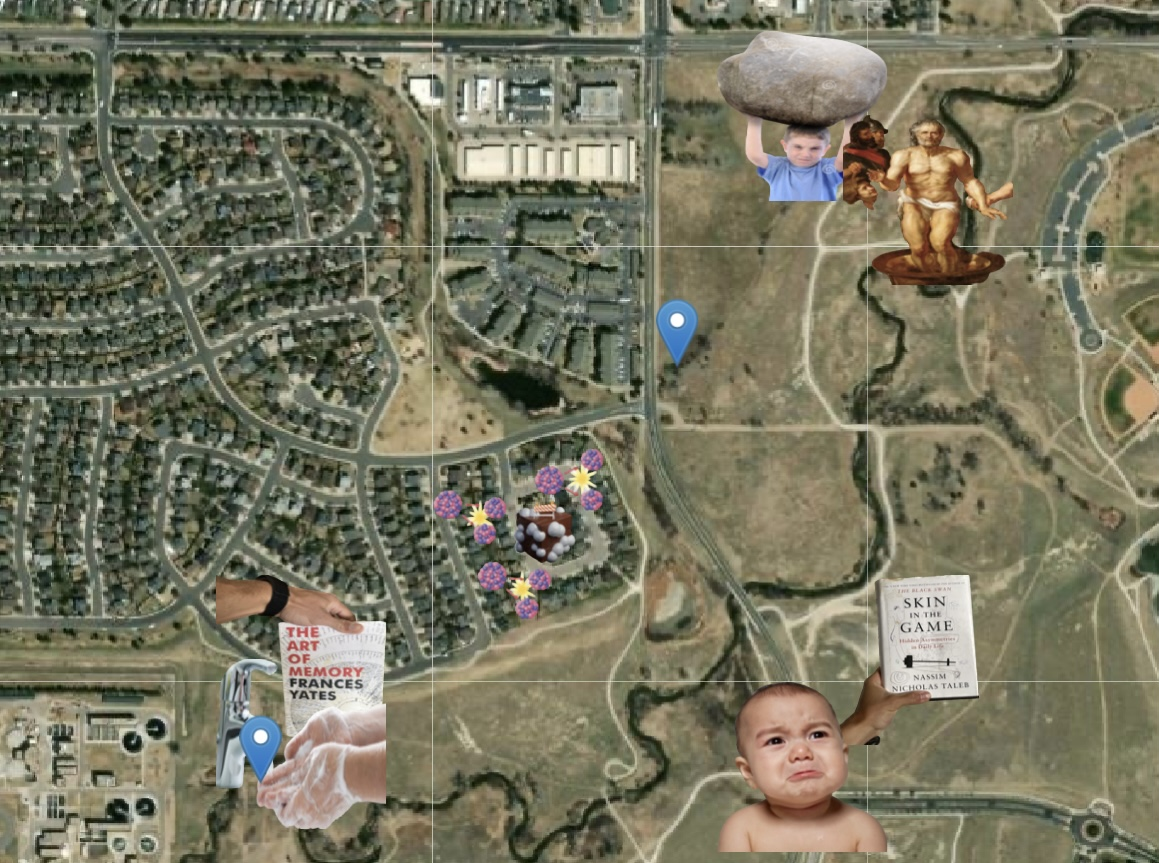